In [1]:
# Activate local environment, see `Project.toml`
import Pkg; 
Pkg.add(["GraphViz"]); Pkg.activate(".."); Pkg.instantiate();
using RxInfer, Random, Plots, GraphViz

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
┌ Warning: The active manifest file at `/ws/Manifest.toml` has an old format that is being maintained.
│ To update to the new format, which is supported by Julia versions ≥ 1.6.2, run `import Pkg; Pkg.upgrade_manifest()` which will upgrade the format without re-resolving.
│ To then record the julia version re-resolve with `Pkg.resolve()` and if there are resolve conflicts consider `Pkg.update()`.
└ @ Pkg.Types /usr/local/julia/share/julia/stdlib/v1.11/Pkg/src/manifest.jl:318
  No Changes to `/ws/Project.toml`
  No Changes to `/ws/Manifest.toml`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /ws/Manifest.toml:0
  Activating project at `/ws`


### Data generation

In [2]:
# Function to return a onehot encoded vector 
# for a Categorical distribution

function rand_vec(rng, distribution::Categorical)
  k = ncategories(distribution)
  s = zeros(k)
  drawn_category = rand(rng, distribution)
  s[drawn_category] = 1
  return s
end


rand_vec (generic function with 1 method)

In [3]:
function generate_data(seed, N)
  rng = MersenneTwister(seed)

  # Transition probabilities 
  state_transition_prob = [1.0 0.0; 0.0 1.0]

  # Emmision probabilities
  emission_prob = [0.8 0.2; 0.2 0.8]
  
  # Initial state
  s_init = [1, 0]

  s = Vector{Vector{Float64}}(undef, N)
  y = Vector{Vector{Float64}}(undef, N)

  s_prev = s_init
  for i in 1:N
    s_prob_vec = state_transition_prob * s_prev
    s[i] = rand_vec(rng, Categorical(s_prob_vec / sum(s_prob_vec)))
    y_prob_vec = emission_prob * s[i]
    y[i] = rand_vec(rng, Categorical(y_prob_vec / sum(y_prob_vec)))
    s_prev = s[i]
  end

  return s, y
end

generate_data (generic function with 1 method)

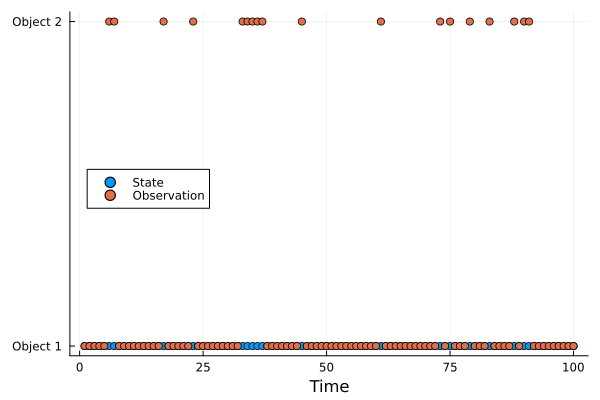

In [4]:
N = 100
seed = 42

s, y = generate_data(seed, N)
scatter(argmax.(s), leg=false, xlabel="Time",yticks= ([1,2],["Object 1","Object 2"]), label="State")
scatter!(argmax.(y), label="Observation")
plot!(legend=:left)

### Model Definition

In [5]:
# Model specification
@model function hidden_markov_model(x)
  
  A ~ MatrixDirichlet([100 1;
                       1 100])
  B ~ MatrixDirichlet([10 1;
                       1 10])

  s_0 ~ Categorical(fill(0.5, 2))
  s_prev = s_0

  for t in eachindex(x)
    s[t] ~ Transition(s_prev, A)
    x[t] ~ Transition(s[t], B)
    s_prev = s[t]
  end
end

# Constraints specification
#   Dit lijkt op de mean-field approximation
@constraints function hidden_markov_model_constraints()
  q(s_0, s, A, B) = q(s_0, s)q(A)q(B)
end

hidden_markov_model_constraints (generic function with 1 method)

In [6]:
imarginals = @initialization begin
  q(A) = vague(MatrixDirichlet, 2, 2)
  q(B) = vague(MatrixDirichlet, 2, 2)
  q(s) = vague(Categorical, 2)
end

ireturnvars = (
  A = KeepLast(),
  B = KeepLast(),
  s = KeepLast()
)

result = infer(
  model       = hidden_markov_model(),
  data        = (x = y,),
  constraints = hidden_markov_model_constraints(),
  initialization = imarginals,
  returnvars  = ireturnvars,
  iterations  = 20,
  free_energy = true
);

In [7]:
println("Posterior Mariginal for A:")
mean(result.posteriors[:A])

Posterior Mariginal for A:


2×2 Matrix{Float64}:
 0.993787    0.012238
 0.00621292  0.987762

In [8]:
println("Posterior Mariginal for B:")
mean(result.posteriors[:B])

Posterior Mariginal for B:


2×2 Matrix{Float64}:
 0.837036  0.0847482
 0.162964  0.915252

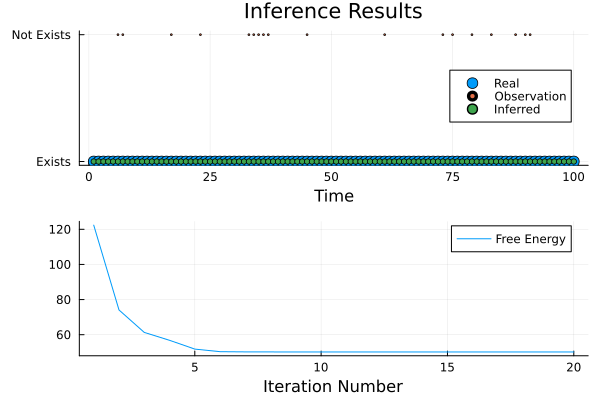

Categorical{Float64, Vector{Float64}}(support=Base.OneTo(2), p=[0.9994983824914258, 0.0005016175085742575])


In [12]:
println(result.posteriors[:s][1])
p1 = scatter(argmax.(s)[1:100],
                        title = "Inference Results",
                        label = "Real",
                        ms = 6, 
                        legend = :right,
                        xlabel = "Time",
                        yticks = ([1, 2], ["Exists", "Not Exists"]),
                        #size = (900, 500)
                        )

p1 = scatter!(argmax.(y)[1:100],
                        label = "Observation",
                        ms = 1
                        )

p1 = scatter!(p1, argmax.(ReactiveMP.probvec.(result.posteriors[:s]))[1:100],
                        label = "Inferred",
                        ms = 3
                        #xlabel = "Iteration Number",
                        )

p2 = plot(result.free_energy,
                      label = "Free Energy",
                      xlabel = "Iteration Number"
                      )

p = plot(p1, p2, layout = @layout([ a; b ]))
savefig(p, "figures/hidden_markov_model.png")
display(p)
